In [1]:
# Sets seeds for reproducability.

import torch

SEED = 123
torch.manual_seed(SEED)

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [2]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import *
from accuracy import *
from transformers import get_linear_schedule_with_warmup
from model import Model
from torch import nn

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions_train=4, batch_size=4, epochs=25, lr=0.001, MAX_DETECTIONS=20, train_set_type= "pseudo", 
          valid_set_type = "fi", eval_fi_error=True):    
     # Validation set defaults to test set for now for diagnosing.
    step_lens = [4, 8] #9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 27]
    
    if train_set_type == "pseudo":
        print("Train set: Pseudo vids of length: {}".format(num_actions_train))
        train_datasets = [YouCookII(num_actions_train, "/h/sagar/ece496-capstone/datasets/ycii_{}".format(num_actions_train))]
    elif train_set_type == "reg":
        print("Train set: YC2 vids of regular length: {}".format(num_actions_train))
        train_datasets = [YouCookII(num_action, "/h/sagar/ece496-capstone/datasets/ycii") for num_action in num_actions_train]
    #for debug only
    elif train_set_type == "fi":
        print("Train set: Finding It eval set of length: {}".format(step_lens))
        train_datasets = [YouCookII(num_action, "/h/sagar/ece496-capstone/datasets/fi") for num_action in step_lens]

    if valid_set_type == "fi":
        print("Validation set: Finding It eval set of length: {}".format(step_lens))
        valid_datasets = [YouCookII(num_action, "/h/sagar/ece496-capstone/datasets/fi") for num_action in step_lens]
    elif valid_set_type == "reg":
        print("Validation set: YC2 vids of regular length: {}".format(num_actions_train))
        valid_datasets = [YouCookII(num_actions_valid, "/h/sagar/ece496-capstone/datasets/ycii")]
    train_size = sum([len(train_dataset) for train_dataset in train_datasets])
    valid_size = sum([len(valid_dataset) for valid_dataset in valid_datasets])
    
    print("Training Dataset Size: {}, Validation Dataset Size: {}".format(train_size, valid_size))
    print("Effective Batch Size: {} * {} = {}".format(num_actions_train, batch_size, num_actions_train * batch_size))
    print("Learning Rate: {}, Epochs: {}".format(lr, epochs))
    
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloaders = [DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
                         for train_dataset in train_datasets]
    valid_dataloaders = [DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=False, worker_init_fn=seed_worker)
                         for valid_dataset in valid_datasets]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    train_accuracy = np.zeros(epochs)
    valid_accuracy = np.zeros(epochs)
    
    fi_top1_ours = []
    fi_top1_best = []
    fi_top1_rand = []
    
    for epoch in range(epochs):
        model.train()
        
        epoch_loss = 0.
        datapoints = 0
        
        for train_dataloader in train_dataloaders:
            for input_data in train_dataloader:
                _, bboxes, features, actions, steps, entities, entity_count, _ = input_data
                
                # Zero out any gradients.
                optimizer.zero_grad()

                # Run inference (forward pass).
                loss_data, VG, RR = model(steps, features, bboxes, entities, entity_count)

                # Loss from alignment.
                loss_ = compute_loss_batched(loss_data)

                # Backpropagation (backward pass).
                loss_.backward()

                # Update parameters.
                optimizer.step()

                epoch_loss += loss_
                datapoints += len(steps) * len(actions[0])
                            
        # Scheduler update.
        scheduler.step()
        epoch_loss = epoch_loss / datapoints
        
        # Save loss and accuracy at each epoch and plot.
        train_loss[epoch] = float(epoch_loss)
        train_accuracy[epoch] = get_alignment_accuracy(model, train_dataloaders) 
        
        valid_loss[epoch] = get_alignment_loss(model, valid_dataloaders)
        valid_accuracy[epoch] = get_alignment_accuracy(model, valid_dataloaders)
        
        if eval_fi_error:
            fi_mean_ours_ep, _, _, fi_top1_ours_ep, fi_top1_best_ep, fi_top1_rand_ep  = eval_all_dataset(model, num_actions_list = [4,8], path="/h/sagar/ece496-capstone/datasets/fi", print_stuff=False)
            
            
            fi_top1_ours.append(fi_top1_ours_ep)
            fi_top1_best.append(fi_top1_best_ep)
            fi_top1_rand.append(fi_top1_rand_ep)
            
            print("Epoch {} - Train Loss: {:.2f}, Validation Loss: {:.2f}, Train Accuracy: {:.2f}, Validation Accuracy: {:.2f}, Top1 FI Acc: {:.2f}"
              .format(epoch + 1, train_loss[epoch], valid_loss[epoch], train_accuracy[epoch], valid_accuracy[epoch], 
                     fi_top1_ours[epoch]*100))
    
            
        else:    
            print("Epoch {} - Train Loss: {:.2f}, Validation Loss: {:.2f}, Train Accuracy: {:.2f}, Validation Accuracy: {:.2f}"
              .format(epoch + 1, train_loss[epoch], valid_loss[epoch], train_accuracy[epoch], valid_accuracy[epoch]))
    
    plt.figure()
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    
    plt.figure()
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='valid accuracy')
    plt.plot(fi_top1_ours, label = "Top 1 Accuracy on FI set")
    plt.legend()
    
    plt.show()
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, input_data

PyTorch version 1.6.0 available.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device)

In [4]:
# Pre train Evaluation.

from eval_fi import eval_all_dataset
eval_all_dataset(model, num_actions_list = [4,8], path="/h/sagar/ece496-capstone/datasets/fi", print_stuff=True)

--------------------------------------------------
Action 1: cut the salmon into slices
Best IoU possible = 0.7365879416465759
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: form the rice into a ball
Best IoU possible = 0.05883581840520223
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.025578459724783897
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: place the rice on the fish slice
Best IoU possible = 0.030926613174429633
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.008144349554009373
Best IoU possible = 0.7772270441055298
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0759255662560463
Mean Upper Bound IoU: 0.4008943438529968, Mean Random IoU: 0.0, Mean Model IoU: 0.027412094175815582
Top-1 acc@0.5:
Proposal Upper Bound: 0.5, Random: 0.0, Model: 0.0
--------------------------------------------------
Action 1: heat two 

Best IoU possible = 0.6344367861747742
Random Candidate IoU = 0.037142179906368256
Chosen Frame IoU: 0.31452158093452454
--------------------------------------------------
Action 7: Cook the flavored beef on a grill
Best IoU possible = 0.6090264320373535
Random Candidate IoU = 0.09323716163635254
Chosen Frame IoU: 0.35740673542022705
Best IoU possible = 0.45831984281539917
Random Candidate IoU = 0.45831984281539917
Chosen Frame IoU: 0.28869348764419556
Mean Upper Bound IoU: 0.5487931370735168, Mean Random IoU: 0.16463296115398407, Mean Model IoU: 0.1268167495727539
Top-1 acc@0.5:
Proposal Upper Bound: 0.5833333333333334, Random: 0.0, Model: 0.0
--------------------------------------------------
Action 1: mix the eggs with salt and pepper
Best IoU possible = 0.5809203443057018
Random Candidate IoU = 0.2576351463794708
Chosen Frame IoU: 0.0196696724742651
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------

(tensor(0.1641),
 tensor(0.5027),
 tensor(0.1268),
 0.0925925925925926,
 0.5541634291634291,
 0.018518518518518517)

Train set: Finding It eval set of length: [4, 8]
Validation set: Finding It eval set of length: [4, 8]
Training Dataset Size: 6, Validation Dataset Size: 6
Effective Batch Size: 4 * 1 = 4
Learning Rate: 5e-05, Epochs: 100
Epoch 1 - Train Loss: 165.96, Validation Loss: 153.61, Train Accuracy: 0.54, Validation Accuracy: 0.45, Top1 FI Acc: 9.26
Epoch 2 - Train Loss: 153.34, Validation Loss: 148.28, Train Accuracy: 0.47, Validation Accuracy: 0.54, Top1 FI Acc: 7.41
Epoch 3 - Train Loss: 141.40, Validation Loss: 150.67, Train Accuracy: 0.48, Validation Accuracy: 0.48, Top1 FI Acc: 5.56
Epoch 4 - Train Loss: 131.94, Validation Loss: 130.05, Train Accuracy: 0.53, Validation Accuracy: 0.55, Top1 FI Acc: 3.70
Epoch 5 - Train Loss: 137.91, Validation Loss: 129.59, Train Accuracy: 0.57, Validation Accuracy: 0.59, Top1 FI Acc: 3.70
Epoch 6 - Train Loss: 126.96, Validation Loss: 118.62, Train Accuracy: 0.57, Validation Accuracy: 0.51, Top1 FI Acc: 3.70
Epoch 7 - Train Loss: 105.84, Validation Loss:

Epoch 67 - Train Loss: 13.54, Validation Loss: 12.26, Train Accuracy: 0.92, Validation Accuracy: 0.91, Top1 FI Acc: 8.92
Epoch 68 - Train Loss: 11.42, Validation Loss: 11.70, Train Accuracy: 0.93, Validation Accuracy: 0.92, Top1 FI Acc: 8.92
Epoch 69 - Train Loss: 10.73, Validation Loss: 12.29, Train Accuracy: 0.92, Validation Accuracy: 0.91, Top1 FI Acc: 10.77
Epoch 70 - Train Loss: 14.15, Validation Loss: 12.14, Train Accuracy: 0.92, Validation Accuracy: 0.91, Top1 FI Acc: 12.06
Epoch 71 - Train Loss: 12.86, Validation Loss: 12.04, Train Accuracy: 0.92, Validation Accuracy: 0.91, Top1 FI Acc: 10.20
Epoch 72 - Train Loss: 13.93, Validation Loss: 11.82, Train Accuracy: 0.92, Validation Accuracy: 0.92, Top1 FI Acc: 10.20
Epoch 73 - Train Loss: 11.79, Validation Loss: 11.19, Train Accuracy: 0.91, Validation Accuracy: 0.91, Top1 FI Acc: 10.20
Epoch 74 - Train Loss: 12.16, Validation Loss: 11.49, Train Accuracy: 0.91, Validation Accuracy: 0.90, Top1 FI Acc: 10.20
Epoch 75 - Train Loss: 11.

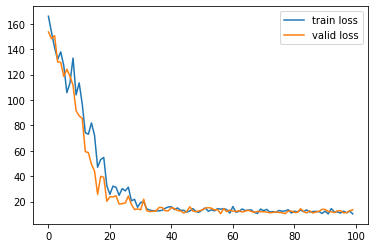

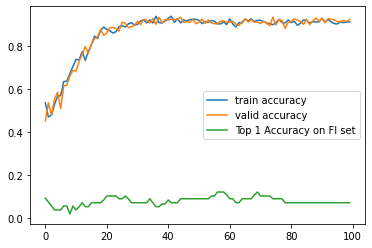

In [5]:
# Trainer. - on FI set

num_actions_train = 4
batch_size = 1
epochs = 100
lr = 5e-5

train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, input_data = train(
    model, 
    num_actions_train=num_actions_train,
    batch_size=batch_size,
    epochs=epochs,
    lr=lr,
    train_set_type = "fi",
    valid_set_type=  "fi",
    eval_fi_error = True
)

In [6]:
# Evaluation.
model.eval()
eval_all_dataset(model, num_actions_list=[4,8], path="/h/sagar/ece496-capstone/datasets/fi", print_stuff=True)

--------------------------------------------------
Action 1: cut the salmon into slices
Best IoU possible = 0.7365879416465759
Random Candidate IoU = 0.08795802523925757
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: form the rice into a ball
Best IoU possible = 0.1695869415998459
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: place the rice on the fish slice
Best IoU possible = 0.06551862602997006
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8352923393249512
Random Candidate IoU = 0.002459530020132661
Chosen Frame IoU: 0.0
Mean Upper Bound IoU: 0.45174646377563477, Mean Random IoU: 0.022604389116168022, Mean Model IoU: 0.0
Top-1 acc@0.5:
Proposal Upper Bound: 0.5, Random: 0.0, Model: 0.0
--------------------------------------------------
Action 1: heat two pieces of bread o

Best IoU possible = 0.46032974123954773
Random Candidate IoU = 0.012443172745406628
Chosen Frame IoU: 0.3613600730895996
Best IoU possible = 0.4587240517139435
Random Candidate IoU = 0.23210512101650238
Chosen Frame IoU: 0.3600996136665344
Mean Upper Bound IoU: 0.45624253153800964, Mean Random IoU: 0.09628722816705704, Mean Model IoU: 0.0873003602027893
Top-1 acc@0.5:
Proposal Upper Bound: 0.4166666666666667, Random: 0.08333333333333333, Model: 0.0
--------------------------------------------------
Action 1: mix the eggs with salt and pepper
Best IoU possible = 0.6271115796914236
Random Candidate IoU = 0.31379660964012146
Chosen Frame IoU: 0.6271115796914236
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: cut the asperagus and tomato into pieces
Best IoU possible = 0.39346814155578613
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.06536009162664413
This entity has no ground truth boun

(tensor(0.1505),
 tensor(0.4820),
 tensor(0.1014),
 0.0707070707070707,
 0.4927156177156176,
 0.013888888888888888)

In [8]:
# Visualizer.

from visualizer import inference

YCII = "/h/sagar/ece496-capstone/datasets/ycii"
FI = "/h/sagar/ece496-capstone/datasets/fi"

VG, RR = inference(model, 27, 0, FI)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
# Saving and loading weights.

SAVE = True
LOAD = False

if SAVE:
    #torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/t3")
    
if LOAD:
    #model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/t1"))

In [7]:
# Reload modules.

import importlib
import visualizer
import eval_fi
import model as mdl
import loss

importlib.reload(visualizer)
importlib.reload(eval_fi)
importlib.reload(mdl)
importlib.reload(loss)
importlib.reload(torch)

<module 'torch' from '/scratch/ssd002/home/mhasan/ece496-capstone/env/lib/python3.7/site-packages/torch/__init__.py'>